In [118]:
# pip install numpy matplotlib seaborn tqdm

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
import copy
import random
import os

In [119]:
# Example Sudoku Puzzle (0 represents empty cells)
sudoku_puzzle = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

def print_sudoku(grid):
    """Utility function to print the Sudoku grid in a readable format."""
    for i in range(9):
        row = ""
        for j in range(9):
            num = grid[i][j]
            row += f"{num} " if num != 0 else ". "
            if (j + 1) % 3 == 0 and j < 8:
                row += "| "
        print(row)
        if (i + 1) % 3 == 0 and i < 8:
            print("- " * 11)

In [120]:
print_sudoku(sudoku_puzzle)

5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
- - - - - - - - - - - 
8 . . | . 6 . | . . 3 
4 . . | 8 . 3 | . . 1 
7 . . | . 2 . | . . 6 
- - - - - - - - - - - 
. 6 . | . . . | 2 8 . 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 


In [121]:

def load_puzzle_from_file(file_path):
    """Loads a Sudoku puzzle from a given file."""
    try:
        with open(file_path, 'r') as file:
            puzzle = []
            for line in file:
                # Split the line by spaces and convert to integers
                row = [int(num) for num in line.strip().split()]
                if len(row) != 9:
                    raise ValueError("Each row must have exactly 9 numbers.")
                puzzle.append(row)
            if len(puzzle) != 9:
                raise ValueError("Puzzle must have exactly 9 rows.")
            return puzzle
    except Exception as e:
        print(f"Error loading puzzle from {file_path}: {e}")
        return None

def list_puzzles(puzzles_dir='puzzles'):
    """Lists all Sudoku puzzle files in the specified directory."""
    try:
        files = sorted([f for f in os.listdir(puzzles_dir) if f.endswith('.txt')])
        if not files:
            print(f"No puzzle files found in the '{puzzles_dir}/' directory.")
            return []
        return files
    except FileNotFoundError:
        print(f"The directory '{puzzles_dir}/' does not exist.")
        return []

def select_puzzle(puzzles):
    """Allows the user to select a puzzle from the list."""
    print("\nAvailable Sudoku Puzzles:")
    for idx, puzzle_name in enumerate(puzzles, start=1):
        print(f"{idx}. {puzzle_name}")
    
    while True:
        try:
            choice = int(input("\nEnter the number of the puzzle you want to solve: "))
            if 1 <= choice <= len(puzzles):
                return puzzles[choice - 1]
            else:
                print(f"Please enter a number between 1 and {len(puzzles)}.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

def print_sudoku(grid):
    """Utility function to print the Sudoku grid in a readable format."""
    for i in range(9):
        row = ""
        for j in range(9):
            num = grid[i][j]
            row += f"{num} " if num != 0 else ". "
            if (j + 1) % 3 == 0 and j < 8:
                row += "| "
        print(row)
        if (i + 1) % 3 == 0 and i < 8:
            print("- " * 11)


In [122]:
def fitness_function(grid):
    """Calculates the fitness of a Sudoku grid.
    Lower fitness scores are better (fewer violations).
    """
    fitness = 0
    # Check rows
    for row in grid:
        fitness += 9 - len(set(row))
    
    # Check columns
    for col in zip(*grid):
        fitness += 9 - len(set(col))
    
    # Check 3x3 subgrids
    for i in range(0,9,3):
        for j in range(0,9,3):
            subgrid = []
            for k in range(3):
                subgrid += grid[i+k][j:j+3]
            fitness += 9 - len(set(subgrid))
    
    return fitness


In [123]:
def initialize_population(puzzle, population_size=100):
    """Initializes the population by filling empty cells with possible numbers without violating row constraints."""
    population = []
    fixed_cells = copy.deepcopy(puzzle)
    
    # Identify fixed cells
    fixed = [[cell != 0 for cell in row] for row in puzzle]
    
    for _ in range(population_size):
        individual = copy.deepcopy(puzzle)
        for i in range(9):
            # Identify missing numbers in the row
            missing = [num for num in range(1,10) if individual[i].count(num) == 0]
            # Identify positions to fill in the row
            empty_indices = [j for j in range(9) if not fixed[i][j]]
            # Shuffle missing numbers to assign randomly
            random.shuffle(missing)
            for idx, j in enumerate(empty_indices):
                individual[i][j] = missing[idx]
        population.append(individual)
    return population, fixed

def crossover(parent1, parent2, fixed):
    """Performs crossover between two parents to produce an offspring without altering fixed cells."""
    child = copy.deepcopy(parent1)
    crossover_point = random.randint(0,8)
    for i in range(crossover_point,9):
        for j in range(9):
            if not fixed[i][j]:
                child[i][j] = parent2[i][j]
    return child

def mutate(individual, fixed, mutation_rate=0.05):
    """Mutates an individual by swapping two cells in a row without altering fixed cells."""
    for i in range(9):
        if random.random() < mutation_rate:
            # Identify mutable cells in the row
            mutable_indices = [j for j in range(9) if not fixed[i][j]]
            if len(mutable_indices) >= 2:
                # Select two distinct cells to swap
                swap_indices = random.sample(mutable_indices, 2)
                # Swap the numbers
                individual[i][swap_indices[0]], individual[i][swap_indices[1]] = \
                individual[i][swap_indices[1]], individual[i][swap_indices[0]]
    return individual

def quantum_inspired_optimization_solver(puzzle, population_size=200, generations=1000, mutation_rate=0.1):
    """Solves Sudoku using a Quantum-Inspired Optimization Algorithm."""
    population, fixed = initialize_population(puzzle, population_size)
    fitness_history = []
    
    for generation in tqdm(range(generations), desc="Optimizing"):
        # Calculate fitness for the population
        fitness_scores = [fitness_function(ind) for ind in population]
        best_fitness = min(fitness_scores)
        fitness_history.append(best_fitness)
        
        # Check if any individual has fitness 0
        if best_fitness == 0:
            index = fitness_scores.index(best_fitness)
            print(f"\nSolution found at generation {generation}")
            return population[index], fitness_history
        
        # Selection: Select top 20% individuals
        sorted_population = [x for _,x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0])]
        survivors = sorted_population[:int(0.2 * population_size)]
        
        # Generate next generation
        next_generation = survivors.copy()
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(survivors, 2)
            child = crossover(parent1, parent2, fixed)
            child = mutate(child, fixed, mutation_rate)
            next_generation.append(child)
        
        population = next_generation
    
    # If no solution found
    best_fitness = min(fitness_history)
    best_individual = population[fitness_scores.index(best_fitness)]
    print("\nNo perfect solution found.")
    return best_individual, fitness_history


In [124]:
def solve_sudoku(puzzle):
    """Solves the Sudoku puzzle using Quantum-Inspired Optimization."""
    solution, fitness_history = quantum_inspired_optimization_solver(
        puzzle,
        population_size=200,
        generations=1000,
        mutation_rate=0.1
    )
    return solution, fitness_history


In [125]:
def visualize_results(initial_puzzle, solution, fitness_history):
    """Visualizes the initial puzzle, the solution, and the fitness over generations."""
    # Plot Initial Puzzle
    plt.figure(figsize=(6,6))
    sns.heatmap(initial_puzzle, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
    plt.title("Initial Sudoku Puzzle")
    plt.show()
    
    # Plot Solution
    plt.figure(figsize=(6,6))
    sns.heatmap(solution, annot=True, fmt='d', cmap='Greens', cbar=False, linewidths=0.5, linecolor='black')
    plt.title("Solved Sudoku Puzzle")
    plt.show()
    
    # Plot Fitness History
    plt.figure(figsize=(10,6))
    plt.plot(fitness_history, color='red')
    plt.xlabel("Generations")
    plt.ylabel("Best Fitness Score")
    plt.title("Fitness Score Over Generations")
    plt.grid(True)
    plt.show()



Available Sudoku Puzzles:
1. sudoku_puzzle_1.txt
2. sudoku_puzzle_2.txt
3. sudoku_puzzle_3.txt
4. sudoku_puzzle_4.txt

Initial Sudoku Puzzle:
. . . | . 5 . | 9 2 . 
1 . . | . 4 2 | 7 6 3 
9 . 2 | . . 7 | . . 5 
- - - - - - - - - - - 
. . . | . . 3 | 1 5 7 
. 5 . | 6 . 9 | . 8 . 
. . . | 5 7 . | . . . 
- - - - - - - - - - - 
5 . . | . 9 8 | 6 . 2 
. 2 7 | 3 . 1 | . . 9 
. 4 9 | 7 . . | 8 3 . 


Optimizing:   2%|▏         | 17/1000 [00:00<00:16, 60.31it/s]



Solution found at generation 17

Solved Sudoku Puzzle:
3 7 4 | 1 5 6 | 9 2 8 
1 8 5 | 9 4 2 | 7 6 3 
9 6 2 | 8 3 7 | 4 1 5 
- - - - - - - - - - - 
4 9 6 | 2 8 3 | 1 5 7 
7 5 3 | 6 1 9 | 2 8 4 
2 1 8 | 5 7 4 | 3 9 6 
- - - - - - - - - - - 
5 3 1 | 4 9 8 | 6 7 2 
8 2 7 | 3 6 1 | 5 4 9 
6 4 9 | 7 2 5 | 8 3 1 


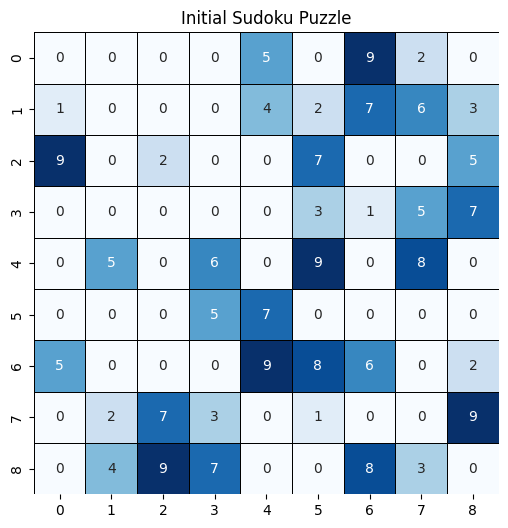

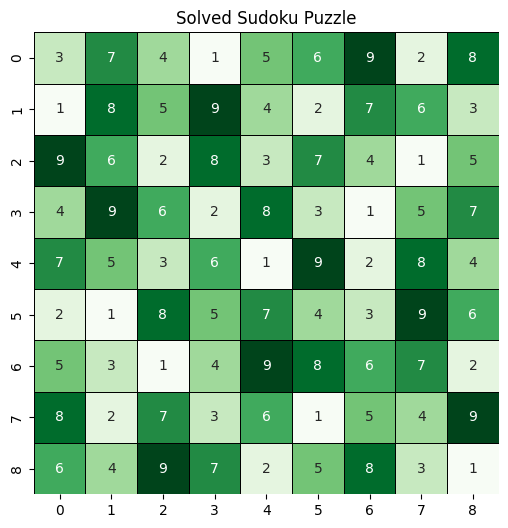

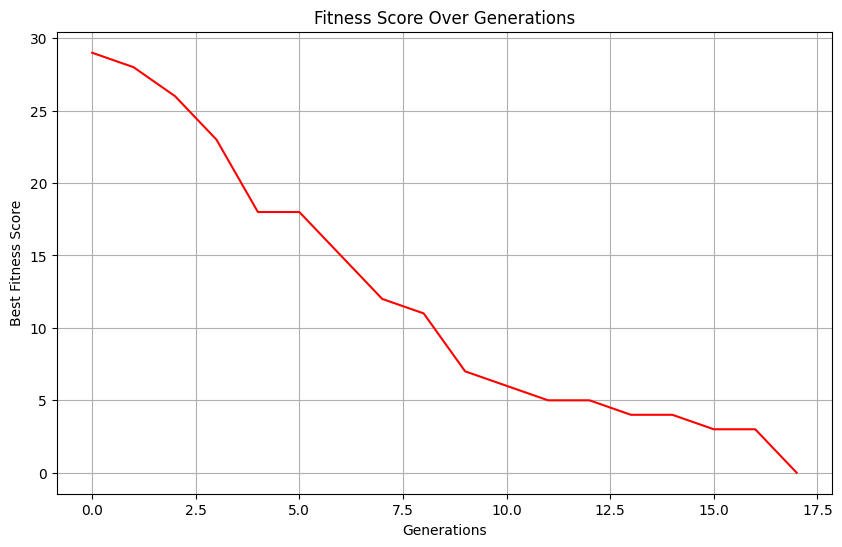

In [ ]:
def main():
    puzzles_dir = 'puzzles'
    puzzles = list_puzzles(puzzles_dir)
    
    if not puzzles:
        print("Please add Sudoku puzzle files to the 'puzzles/' directory and try again.")
        return
    
    selected_puzzle_file = select_puzzle(puzzles)
    puzzle_path = os.path.join(puzzles_dir, selected_puzzle_file)
    puzzle = load_puzzle_from_file(puzzle_path)
    
    if puzzle is None:
        print("Failed to load the selected puzzle. Exiting.")
        return
    
    print("\nInitial Sudoku Puzzle:")
    print_sudoku(puzzle)
    
    solution, fitness_history = solve_sudoku(puzzle)
    
    print("\nSolved Sudoku Puzzle:")
    print_sudoku(solution)
    
    # visualize_results(puzzle, solution, fitness_history) ## THIS PRINTS THE VISUALS

if __name__ == "__main__":
    main()
